In [1]:
import os,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

import keras
from keras.utils import np_utils
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
# get the data
filname = 'fer2013/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [4]:
a = df['emotion']
idx = pd.Index(a)
count = idx.value_counts()
print(count)

3          8989
6          6198
4          6077
2          5121
0          4953
5          4002
1           547
emotion       1
Name: emotion, dtype: int64


In [6]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        #This condition skips the first condition
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    #X, Y = np.array(X) / 255.0, np.array(Y)
    X, Y = np.array(X)/255.0 , np.array(Y)
    return X, Y

In [7]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


Preprocess Image to detect only face

In [8]:
X.shape

(35887, 2304)

In [9]:
# keras with tensorflow backend
N,D = X.shape
X = X.reshape(N, 48, 48, 1)

**Split Train Test data**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

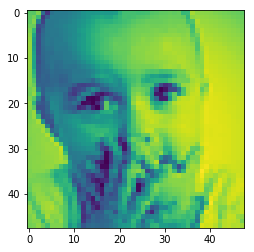

In [11]:
img = X_train[780].reshape(48,48)
plt.imshow(img, interpolation='nearest')
plt.show()

In [12]:
from keras.applications import VGG19
#Load the VGG model
vgg_conv = VGG19(weights=None, include_top=False, input_shape=(48, 48,1))

In [13]:
def vgg_custom():
    model = Sequential()
    #add vgg conv model
    model.add(vgg_conv)
    
    #add new layers
    model.add(Flatten())
    model.add(Dense(7,  kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Adadelta())
    #model.compile(loss='mean_squared_error', optimizer=Adam())
    
    return model

In [14]:
model = vgg_custom()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20023232  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 20,026,823
Trainable params: 20,026,823
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras import callbacks
filename='model_train_new.csv'
filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

Image Augmentation

In [16]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

Define Batch Size and Epoch iteration

In [17]:
BS =8
EPOCHS = 50

In [18]:
len(X_train)

28709

Fit augmentated Data into model

In [19]:
history = model.fit(
    X_train, y_train, batch_size=BS,
    validation_data=(X_test, y_test),
    epochs=EPOCHS, verbose=1,
    callbacks = callbacks_list 
    ,shuffle = True
    )

Train on 28709 samples, validate on 7178 samples
Epoch 1/50
28709/28709 [==============================] - 112s 4ms/step - loss: 0.1186 - val_loss: 0.1185
Epoch 2/50
28709/28709 [==============================] - 102s 4ms/step - loss: 0.1184 - val_loss: 0.1184
Epoch 3/50
28709/28709 [==============================] - 101s 4ms/step - loss: 0.1184 - val_loss: 0.1186
Epoch 4/50
  648/28709 [..............................] - ETA: 1:37 - loss: 0.1191

In [20]:
#Model Save
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

In [21]:
hist = history

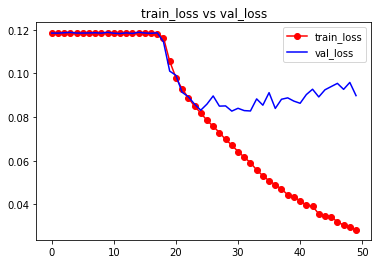

<Figure size 432x288 with 0 Axes>

In [22]:
# visualizing losses and accuracy
# %matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
#train_acc=hist.history['acc']
#val_acc=hist.history['val_acc']

epochs = range(len(val_loss))

plt.plot(epochs,train_loss,'r-o', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
#plt.plot(epochs,train_loss,'r-o', label='train_acc')
#plt.plot(epochs,val_loss,'b', label='val_acc')
#plt.title('train_acc vs val_acc')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()
#plt.savefig('train_test_acc.png')
plt.savefig('train_test.png')

In [ ]:
#train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
epochs=range(len(val_acc))
plt.plot(epochs,train_acc,'r-o', label='train_acc')
plt.plot(epochs, val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()
plt.savefig('Acc_Train_Val.png')

In [24]:
print(train_loss)

[0.11855908616764294, 0.11842907968608932, 0.11838879445389631, 0.1184295225701506, 0.11842572702551474, 0.11842061663260259, 0.11843349138068665, 0.1184283441078028, 0.118461940968924, 0.11840577965399918, 0.11844989509423319, 0.11843725812345252, 0.11846803363222261, 0.11842679428842076, 0.11843006439311589, 0.11847248701934401, 0.11847113633333127, 0.11815907602278582, 0.11637183834303176, 0.105570076128782, 0.09804721897001936, 0.09293023920196439, 0.08882574293239641, 0.0849769448540258, 0.08188359991788839, 0.07851003124111477, 0.07577913117550347, 0.07293307900015096, 0.06973430550876152, 0.06718300157327672, 0.06422038333270352, 0.06163000483412304, 0.059098802589418825, 0.0558196900482446, 0.053116632108754856, 0.05085504408422301, 0.0490602557174816, 0.04703899426459562, 0.04444685037417466, 0.043522028848131146, 0.041641408815371574, 0.039707824293403804, 0.039227224493065066, 0.03567013764265909, 0.03489506371707796, 0.034436403515988506, 0.03195872175394648, 0.030613498446

In [25]:
print(val_loss)

[0.11847006167316543, 0.11842500765315667, 0.11861256099189016, 0.11877626776446137, 0.1184539941940576, 0.11846830556571368, 0.11851591207284255, 0.11860136370135403, 0.11842821177648415, 0.11881272191289209, 0.11840588908967417, 0.11823809402430413, 0.11855937240556542, 0.1182858130644709, 0.1188369933199205, 0.11849290492907312, 0.11835013161000517, 0.1185793251289103, 0.11443806187825536, 0.10103295489784468, 0.09912892916792779, 0.09134772695200329, 0.08931349688301714, 0.08593053956339372, 0.08314212692310366, 0.08593167935587065, 0.08967014356065042, 0.08501016413785183, 0.08510594099228612, 0.08273012305649584, 0.08402174920586863, 0.08296253122586532, 0.08279041918739365, 0.08831901297463153, 0.0854419044741318, 0.09117737573364687, 0.08396258990143578, 0.08815373889904694, 0.0887977896581564, 0.08729700154790176, 0.08631573645120362, 0.090297746195181, 0.09274330845387592, 0.08922004027307183, 0.09248693883481315, 0.09396501334721945, 0.09543156377528995, 0.09269449171083664,

In [26]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score)

test_image = X_test[0:1]
print (test_image.shape)

#predict
y_pred = model.predict(X_test) 

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

res = model.predict_classes(X_test[9:18])
plt.figure(figsize=(10, 10))

Test Loss: 0.08981917751602689
(1, 48, 48, 1)
[[-0.00246421 -0.00262576 -0.00140199  0.8853971   0.0199521   0.02601492
   0.07601154]]
[3]
[[0. 0. 0. 1. 0. 0. 0.]]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [27]:
from sklearn.metrics import confusion_matrix
results = model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
#cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

Confusion Matrix

In [28]:
import seaborn as sns

In [29]:
label_mapdisgust = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [30]:
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )

In [31]:
final_cm = cm_df.drop('Disgust',axis=0)
final_cm = final_cm.drop('Disgust',axis=1)

In [32]:
final_cm

,Anger,Fear,Happy,Sad,Surprise,Neutral
Anger,494,165,43,139,13,128
Fear,123,486,39,206,73,115
Happy,71,85,1375,94,27,112
Sad,140,193,69,567,11,227
Surprise,36,125,55,29,520,29
Neutral,94,119,104,242,23,696


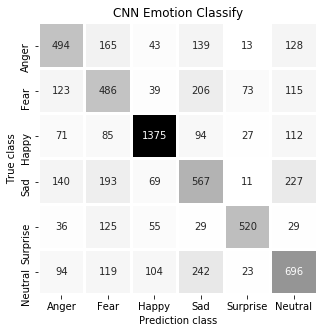

In [33]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

ROC Curve

In [34]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle

In [35]:
new_label = ['Anger', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
final_label = new_label
new_class = 6

In [36]:
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

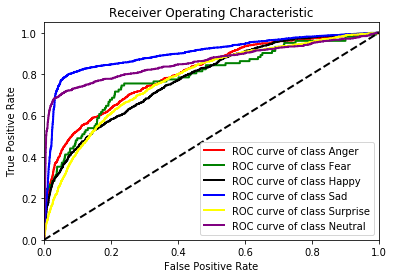

In [37]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()